In [3]:
import sqlite3
import pandas as pd

# Connect to database
conn = sqlite3.connect("supply_chain_real.db")

# Load tables into DataFrames
products_df = pd.read_sql("SELECT * FROM Products", conn)
orders_df = pd.read_sql("SELECT * FROM Orders", conn)
inventory_df = pd.read_sql("SELECT * FROM Inventory", conn)
suppliers_df = pd.read_sql("SELECT * FROM Suppliers", conn)
reviews_df = pd.read_sql("SELECT * FROM Reviews", conn)

# Quick check
print(products_df.head())
print(orders_df.head())


   Product_ID Product_Name     Category  Price  Cost
0           1    Product_1    Furniture   1382   995
1           2    Product_2         Toys    819   802
2           3    Product_3  Electronics    393   209
3           4    Product_4    Furniture   1487   977
4           5    Product_5    Furniture    855   706
   Order_ID  Product_ID  Quantity  Order_Date
0         1           5        14  2025-10-23
1         2          11        12  2026-01-01
2         3          18         6  2025-10-16
3         4          19         7  2025-08-28
4         5          11         5  2025-08-10


In [4]:
# Merge Orders with Products
sales_df = orders_df.merge(products_df, on="Product_ID")
sales_df['Revenue'] = sales_df['Quantity'] * sales_df['Price']
sales_df['Profit'] = sales_df['Quantity'] * (sales_df['Price'] - sales_df['Cost'])

# Aggregate revenue and profit per product
product_perf = sales_df.groupby('Product_Name')[['Revenue','Profit']].sum().reset_index()
product_perf = product_perf.sort_values('Revenue', ascending=False)

print("Product Performance:\n", product_perf)


Product Performance:
    Product_Name  Revenue  Profit
8    Product_17    52400   48400
9    Product_18    52072   12512
18    Product_8    51255    5610
11    Product_2    42588     884
15    Product_5    41040    7152
10   Product_19    39760   26554
0     Product_1    37314   10449
1    Product_10    35786   28159
12   Product_20    34454   20976
7    Product_16    33522    8880
14    Product_4    29740   10200
17    Product_7    29095   15709
6    Product_15    25504   -1312
3    Product_12    19418   12082
2    Product_11    18324  -12312
13    Product_3    14541    6808
5    Product_14    12684   -8484
16    Product_6     5655   -7046
19    Product_9     3912   -3120
4    Product_13     2982   -3318


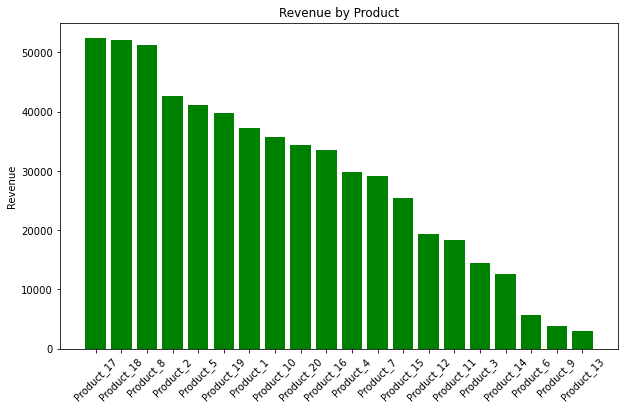

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(product_perf['Product_Name'], product_perf['Revenue'], color='green')
plt.xticks(rotation=45)
plt.ylabel("Revenue")
plt.title("Revenue by Product")
plt.show()


In [6]:
inventory_perf = inventory_df.merge(products_df[['Product_ID','Product_Name']], on='Product_ID')
inventory_perf['Stock_Risk'] = inventory_perf['Stock_Level'] < inventory_perf['Reorder_Level']

print("Inventory Risk:\n", inventory_perf[['Product_Name','Stock_Level','Reorder_Level','Stock_Risk']])


Inventory Risk:
    Product_Name  Stock_Level  Reorder_Level  Stock_Risk
0     Product_1            8              8       False
1     Product_2           29             10       False
2     Product_3           18             17       False
3     Product_4           13             19        True
4     Product_5           30              6       False
5     Product_6            6             14        True
6     Product_7           24             16       False
7     Product_8           32              6       False
8     Product_9           11             14        True
9    Product_10           48             18       False
10   Product_11           12              8       False
11   Product_12           39             18       False
12   Product_13           18             19        True
13   Product_14           21             19       False
14   Product_15           40             12       False
15   Product_16           44             18       False
16   Product_17            8   

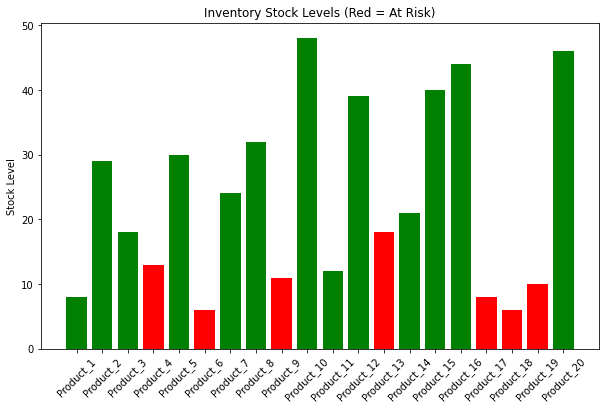

In [7]:
plt.figure(figsize=(10,6))
colors = ['red' if x else 'green' for x in inventory_perf['Stock_Risk']]
plt.bar(inventory_perf['Product_Name'], inventory_perf['Stock_Level'], color=colors)
plt.xticks(rotation=45)
plt.ylabel("Stock Level")
plt.title("Inventory Stock Levels (Red = At Risk)")
plt.show()


In [8]:
supplier_perf = suppliers_df.merge(products_df[['Product_ID','Product_Name']], on='Product_ID')
supplier_perf['Risk_Score'] = supplier_perf['Delivery_Days'] / supplier_perf['Reliability_Score']

print("Supplier Risk:\n", supplier_perf[['Product_Name','Delivery_Days','Reliability_Score','Risk_Score']])


Supplier Risk:
    Product_Name  Delivery_Days  Reliability_Score  Risk_Score
0     Product_1              9               0.94    9.574468
1     Product_2              6               0.88    6.818182
2     Product_3              3               0.98    3.061224
3     Product_4              6               0.90    6.666667
4     Product_5              9               0.97    9.278351
5     Product_6             11               0.96   11.458333
6     Product_7             10               0.83   12.048193
7     Product_8             10               0.73   13.698630
8     Product_9              2               0.81    2.469136
9    Product_10             10               0.90   11.111111
10   Product_11              8               0.90    8.888889
11   Product_12             10               0.88   11.363636
12   Product_13              9               0.78   11.538462
13   Product_14              2               0.87    2.298851
14   Product_15              9               0.81   11

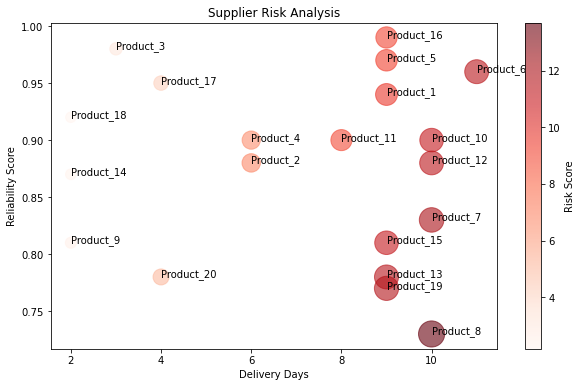

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(supplier_perf['Delivery_Days'], supplier_perf['Reliability_Score'], 
            s=supplier_perf['Risk_Score']*50, c=supplier_perf['Risk_Score'], cmap='Reds', alpha=0.6)
for i, txt in enumerate(supplier_perf['Product_Name']):
    plt.annotate(txt, (supplier_perf['Delivery_Days'][i], supplier_perf['Reliability_Score'][i]))
plt.xlabel("Delivery Days")
plt.ylabel("Reliability Score")
plt.title("Supplier Risk Analysis")
plt.colorbar(label='Risk Score')
plt.show()


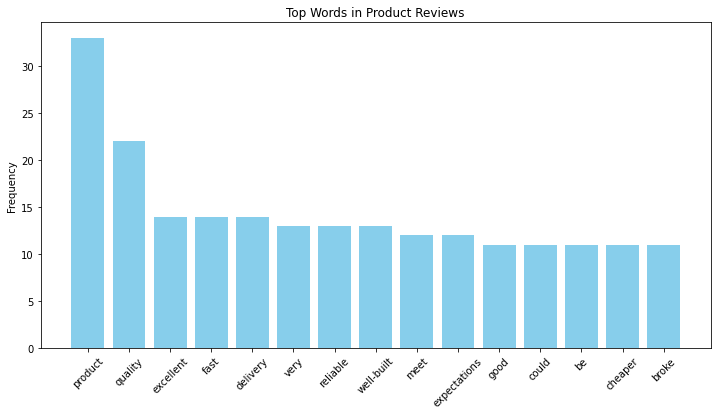

In [11]:
# Count frequency of words in reviews (simple approach)
from collections import Counter
import matplotlib.pyplot as plt

# Combine all review texts
all_text = " ".join(reviews_df['Review_Text'].tolist()).lower()

# Split into words and remove common stopwords
stopwords = ['the','and','but','for','with','a','an','is','was','of','to','does','not']
words = [word.strip('.,') for word in all_text.split() if word not in stopwords]

# Count word frequencies
word_counts = Counter(words)
top_words = word_counts.most_common(15)  # Top 15 words
words, counts = zip(*top_words)

# Plot bar chart
plt.figure(figsize=(12,6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.title("Top Words in Product Reviews")
plt.show()


In [12]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Aggregate sales per product
sales_agg = sales_df.groupby('Product_ID')[['Quantity','Revenue']].sum().reset_index()
X = sales_agg[['Quantity']].values
y = sales_agg['Revenue'].values

# Train Linear Regression
model = LinearRegression()
model.fit(X, y)

# Predict revenue for future quantities
future_quantities = np.array([10,15,5,8,12,7,20,9,6,11]).reshape(-1,1)
predicted_revenue = model.predict(future_quantities)
print("Predicted Revenue for Future Quantities:", predicted_revenue)


Predicted Revenue for Future Quantities: [15680.53932146 18002.64324509 13358.43539784 14751.69775202
 16609.38089091 14287.27696729 20324.74716871 15216.11853674
 13822.85618257 16144.96010619]


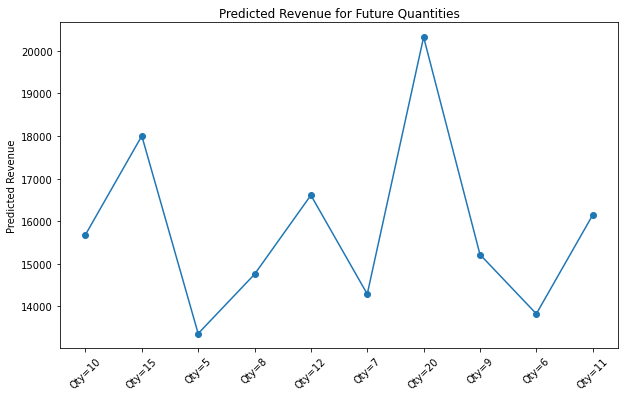

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(len(predicted_revenue)), predicted_revenue, marker='o')
plt.xticks(range(len(predicted_revenue)), [f"Qty={q}" for q in future_quantities.flatten()], rotation=45)
plt.ylabel("Predicted Revenue")
plt.title("Predicted Revenue for Future Quantities")
plt.show()


In [14]:
import os
print(os.getcwd())  # Current working directory


C:\Users\Muskan
